In [733]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)
import numpy as np
from datetime import datetime, date

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import auc, log_loss


from heamy.dataset import Dataset
from sklearn.datasets import load_boston
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier



from time import gmtime, strftime

In [840]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dataset = train.drop('Business_Sourced', axis=1)
dataset = dataset.append(test, ignore_index=True)
dataset = dataset.drop('ID', axis=1)

print train.shape, test.shape, dataset.shape

(9527, 23) (5045, 22) (14572, 21)


In [841]:
print '=== Train Null Counts ==='
#print train.isnull().sum()
print '\n=== Test Null Counts === '
#print test.isnull().sum()
print '\n=== Dataset Null Counts === '
print dataset.isnull().sum()
#print dataset.dtypes

=== Train Null Counts ===

=== Test Null Counts === 

=== Dataset Null Counts === 
Office_PIN                        0
Application_Receipt_Date          0
Applicant_City_PIN              131
Applicant_Gender                 89
Applicant_BirthDate              96
Applicant_Marital_Status        103
Applicant_Occupation           2225
Applicant_Qualification         130
Manager_DOJ                    1507
Manager_Joining_Designation    1507
Manager_Current_Designation    1507
Manager_Grade                  1507
Manager_Status                 1507
Manager_Gender                 1507
Manager_DoB                    1507
Manager_Num_Application        1507
Manager_Num_Coded              1507
Manager_Business               1507
Manager_Num_Products           1507
Manager_Business2              1507
Manager_Num_Products2          1507
dtype: int64


In [842]:
def calculate_age(born):
    born = datetime.strptime(born, '%m/%d/%Y')
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def get_month(receipt_date):
    receipt_date = datetime.strptime(receipt_date, '%m/%d/%Y')
    return receipt_date.month

def shorten_qualification(x):
    if x in ['Class X', 'Others']:
        return 'Others'
    elif x == 'Class XII':
        return x
    return 'Graduate'
def shorten_occupation(x):
    if x not in ['Salaried', 'Business']:
        return 'Others'
    return x

def manager_grade(x):
    if x == 1:
        return 2
    elif x >= 5:
        return 5
    return x
def manager_level(x):
    if x in ['Level 5', 'Level 6', 'Level 7', 'Other']:
        return 'Level 4'
    return x

def products(x):
    if x > 0 and x <= 25:
        return 1
    elif x > 25 and x <= 50:
        return 2
    elif x > 50:
        return 3
    return x

def num_coded(x):
    if x >= 3:
        return 3
    return x

def application(x):
    if x in [3,4]:
        return 3
    elif x > 4:
        return 4
    return x

In [843]:
dataset['Applicant_Qualification'] = dataset['Applicant_Qualification'].apply(lambda x: shorten_qualification(str(x)))
dataset['Business'] =  dataset['Manager_Business'] + dataset['Manager_Business2']
dataset['Products'] = dataset['Manager_Num_Products'] + dataset['Manager_Num_Products2']
dataset['Business'] = (dataset['Business'] - dataset['Business'].mean())/ (dataset['Business'].max() - dataset['Business'].min())
dataset.loc[dataset['Business'].isnull(), 'Business'] = 0
dataset.loc[dataset['Products'].isnull(), 'Products'] = dataset['Products'].median()
dataset['Manager_Grade'] = dataset['Manager_Grade'].apply( lambda x : manager_grade(x))
dataset['Manager_Joining_Designation'] = dataset['Manager_Joining_Designation'].apply(lambda x : manager_level(x))
dataset['Manager_Current_Designation'] = dataset['Manager_Current_Designation'].apply(lambda x : manager_level(x))
dataset['Manager_Num_Coded'] = dataset['Manager_Num_Coded'].apply(lambda x: num_coded(x))
dataset['Manager_Num_Application'] = dataset['Manager_Num_Application'].apply(lambda x : application(x))
dataset['Products'] = dataset['Products'].apply(lambda x : products(x))


#dataset['Applicant_Occupation'] = dataset['Applicant_Occupation'].apply(lambda x : shorten_occupation(str(x)))
dataset['Application_Receipt_Date'] = dataset['Application_Receipt_Date'].apply(lambda x : get_month(x))

dataset.loc[dataset['Applicant_City_PIN'].isnull(), 'Applicant_City_PIN'] = 100000  # Fill Applicant_City_PIN with 100000
dataset.loc[dataset['Applicant_Gender'].isnull(), 'Applicant_Gender'] = 'M'  # Fill Applicant_Gender with M

# Handle Birthday by converting it to Age
dataset['Applicant_Age'] = dataset[dataset['Applicant_BirthDate'].notnull()]['Applicant_BirthDate'].apply(lambda x : calculate_age(str(x)))
dataset.loc[dataset['Applicant_Age'].isnull(), 'Applicant_Age'] = dataset['Applicant_Age'].median()
#dataset['Applicant_Age'] = pd.qcut(dataset['Applicant_Age'], 4, labels=['Fresher', 'Associate', 'Experienced', 'Senior'])

dataset.loc[dataset['Applicant_Marital_Status'].isnull(),'Applicant_Marital_Status'] = 'M' # Fill Marital Status with M
dataset.loc[dataset['Applicant_Occupation'].isnull(), 'Applicant_Occupation'] = 'Unknown' # Make new category for null occupation
dataset.loc[dataset['Applicant_Qualification'].isnull(), 'Applicant_Qualification'] = 'Class XII' # For now assign nulls to class-12

dataset['Manager_Age'] = dataset.loc[dataset['Manager_DoB'].notnull()]['Manager_DoB'].apply(lambda x : calculate_age(str(x)))
dataset.loc[dataset['Manager_Age'].isnull(), 'Manager_Age'] = dataset['Manager_Age'].median()
dataset.loc[dataset['Manager_Gender'].isnull(), 'Manager_Gender'] = 'M'
dataset.loc[dataset['Manager_Num_Coded'].isnull(), 'Manager_Num_Coded'] = dataset['Manager_Num_Coded'].median()
dataset.loc[dataset['Manager_Num_Application'].isnull(), 'Manager_Num_Application'] = dataset['Manager_Num_Application'].median()
dataset.loc[dataset['Manager_Num_Products'].isnull(), 'Manager_Num_Products'] = 0
dataset.loc[dataset['Manager_Num_Products2'].isnull(), 'Manager_Num_Products2'] = 0

dataset['Manager_Business'] = dataset['Manager_Business'].apply(lambda x : str(x))
dataset['Manager_Business2'] = dataset['Manager_Business2'].apply(lambda x : str(x))
dataset['Manager_Age_DOJ'] = dataset.loc[dataset['Manager_DOJ'].notnull()]['Manager_DOJ'].apply(lambda x : get_month(x))
dataset.loc[dataset['Manager_Age_DOJ'].isnull(), 'Manager_Age_DOJ'] = dataset['Manager_Age_DOJ'].median()

enc = LabelEncoder()
dataset['Manager_Business'] = enc.fit_transform(dataset['Manager_Business'])
dataset['Manager_Business2'] = enc.fit_transform(dataset['Manager_Business2'])
dataset['Applicant_City_PIN'] = enc.fit_transform(dataset['Applicant_City_PIN'])
dataset['Office_PIN'] = enc.fit_transform(dataset['Office_PIN'])
#dataset['Applicant_Age'] = enc.fit_transform(dataset['Applicant_Age'])

#encode_columns = ['Manager_Business', 'Manager_Business2']
#dataset[encode_columns] = enc.fit_transform(dataset[encode_columns])

dataset = dataset.drop(['Applicant_BirthDate', 'Manager_DoB', 'Manager_DOJ', 'Manager_Business', 'Manager_Business2', 
                       'Manager_Num_Products', 'Manager_Num_Products2'], axis=1)
dummy_columns = [
 'Applicant_Gender',
 'Applicant_Marital_Status',
 'Applicant_Occupation',
 'Applicant_Qualification',
 'Manager_Joining_Designation',
 'Manager_Current_Designation',
 'Manager_Grade',
 'Manager_Status',
 'Manager_Gender',
'Manager_Num_Coded',
    'Manager_Num_Application',
    'Products'
]

dataset =pd.get_dummies(dataset, columns=dummy_columns)
dataset.head()

,Office_PIN,Application_Receipt_Date,Applicant_City_PIN,Business,Applicant_Age,Manager_Age,Manager_Age_DOJ,Applicant_Gender_F,Applicant_Gender_M,Applicant_Marital_Status_D,...,Manager_Num_Coded_3.0,Manager_Num_Application_0.0,Manager_Num_Application_1.0,Manager_Num_Application_2.0,Manager_Num_Application_3.0,Manager_Num_Application_4.0,Products_0.0,Products_1.0,Products_2.0,Products_3.0
0,95,4,3662,0.046033,44.0,38.0,11.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,95,4,3655,0.046033,33.0,38.0,11.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,84,4,3652,0.051740,50.0,47.0,5.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,89,4,3439,0.041638,28.0,37.0,8.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,89,4,3456,0.018754,31.0,45.0,5.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [844]:
train_x = dataset.ix[0:9526,]
train_y = train['Business_Sourced']

test_x = dataset.ix[9527:14571,]
target = 'Business_Sourced'

train_x = pd.concat([train_x, train_y], axis=1)
predictors = [x for x in train_x.columns if x not in [target]]

In [845]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=500,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

In [846]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
        
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    features = feat_imp
    
    prediction = pd.DataFrame(alg.predict(dtest))
    prediction = pd.concat([test['ID'], prediction], axis=1)
    #prediction.to_csv('submit.csv', index=False)
    prediction.columns = ['ID', 'Business_Sourced']
    prediction['Business_Sourced'].value_counts()
    prediction.to_csv('draft_new.csv', index=False)
    return features


Model Report
Accuracy : 0.7771
AUC Score (Train): 0.868221


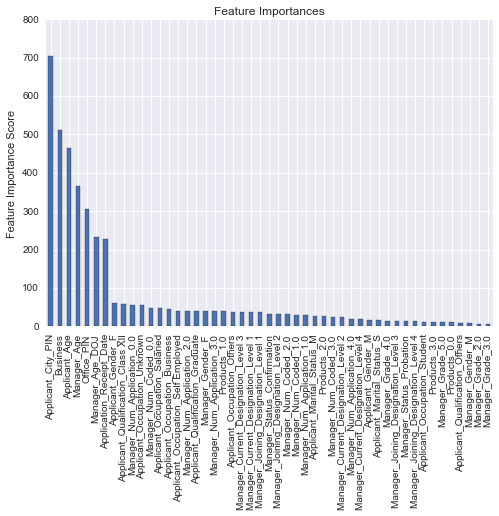

In [847]:
features = modelfit(xgb1, train_x, test_x, predictors)

In [848]:
features

Applicant_City_PIN                     705
Business                               512
Applicant_Age                          466
Manager_Age                            367
Office_PIN                             306
Manager_Age_DOJ                        232
Application_Receipt_Date               227
Applicant_Gender_F                      61
Applicant_Qualification_Class XII       57
Manager_Num_Application_0.0             55
Applicant_Occupation_Unknown            55
Manager_Num_Coded_0.0                   48
Applicant_Occupation_Salaried           48
Applicant_Occupation_Business           46
Applicant_Occupation_Self Employed      41
Manager_Num_Application_2.0             40
Applicant_Qualification_Graduate        40
Manager_Gender_F                        40
Manager_Num_Application_3.0             39
Products_1.0                            39
Applicant_Occupation_Others             38
Manager_Current_Designation_Level 3     37
Manager_Current_Designation_Level 1     37
Manager_Joi

In [850]:
# Model Stacking
new_features = features[features>=50].index
train_xf = train_x[new_features]
test_xf = test_x[new_features]
dataset_f = Dataset(train_x[predictors].astype(np.float64), train_x['Business_Sourced'], test_x.astype(np.float64))
dataset_xf = Dataset(train_xf.astype(np.float64), train_x['Business_Sourced'], test_xf.astype(np.float64))

In [807]:
xgb_params = {
        'learning_rate': 0.01,
        'max_depth': 10,
        'n_estimators': 1000,
        # 'num_class': 5,
        'objective': 'binary:logistic',
    'min_child_weight': 3,
        'subsample': 0.8}

model_xgb = Classifier(dataset=dataset_f, estimator=xgb.sklearn.XGBClassifier, parameters=xgb_params, name='xgb')
model_xgb_xf = Classifier(dataset=dataset_xf, estimator=xgb.sklearn.XGBClassifier, parameters=xgb_params, name='xgb_f')
model_rf = Classifier(dataset=dataset_f, estimator=RandomForestClassifier, parameters={'n_estimators': 700},name='rf')
model_bag = Classifier(dataset=dataset_f, estimator=BaggingClassifier,  parameters={'max_samples':0.9, 'max_features':0.9},name='bag')
model_gb = Classifier(dataset=dataset_f, estimator=GradientBoostingClassifier, parameters={'n_estimators' : 1000, 
                                                                                           'max_depth' : 10, 
                                                                                           'max_features':'sqrt',
                                                                                           'learning_rate' : 0.01 }, name = 'gb')

In [ ]:
xgb_params = {
        'learning_rate': 0.01,
        'max_depth': 8,
        'n_estimators': 1500,
        # 'num_class': 5,
        'objective': 'binary:logistic',
    'min_child_weight': 8,
        'subsample': 0.7}

model_xgb = Classifier(dataset=dataset_f, estimator=xgb.sklearn.XGBClassifier, parameters=xgb_params, name='xgb')
model_xgb_xf = Classifier(dataset=dataset_f, estimator=xgb.sklearn.XGBClassifier, parameters=xgb_params, name='xgb_f')
model_rf = Classifier(dataset=dataset_f, estimator=RandomForestClassifier, parameters={'n_estimators': 700},name='rf')


# In[582]:

pipeline = ModelsPipeline(model_xgb, model_rf, model_xgb_xf)
stack_ds = pipeline.stack(k=5, full_test=True, seed=111)
stacker = Classifier(stack_ds, LogisticRegression)

In [ ]:
weights = pipeline.find_weights(mean_absolute_error)
result = pipeline.weight(weights)

In [835]:
prediction = pd.DataFrame(stacker.predict(), columns=['Business_Sourced'])
def transform_data(x):
        if x <= 0.36:
            return 0
        return 1
prediction['Business_Sourced'] = prediction['Business_Sourced'].apply( lambda x : transform_data(x))
prediction['Business_Sourced'].value_counts()


0    3006
1    2039
Name: Business_Sourced, dtype: int64

In [836]:
prediction = pd.concat([test['ID'], prediction['Business_Sourced']], axis=1)
prediction.to_csv('submit_'+ str(strftime("%Y-%m-%d %H:%M:%S", gmtime())) + '.csv', index=False)